In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.ESRNN import ESRNN
plt.style.use('ggplot')
pd.options.display.max_rows = 999
np.set_printoptions(threshold=np.inf)

In [2]:
# Plot
def plot_prediction(y, y_hat):
    n_y = len(y)
    n_yhat = len(y_hat)
    ds_y = np.array(range(n_y))
    ds_yhat = np.array(range(n_y, n_y+n_yhat))

    plt.plot(ds_y, y, label = 'y')
    plt.plot(ds_yhat, y_hat, label='y_hat')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
def ffill_missing_dates_particular_serie(serie, min_date, max_date, freq):
    date_range = pd.date_range(start=min_date, end=max_date, freq=freq)
    unique_id = serie['unique_id'].unique()
    df_balanced = pd.DataFrame({'ds':date_range, 'key':[1]*len(date_range), 'unique_id': unique_id[0]})

    # Check balance
    check_balance = df_balanced.groupby(['unique_id']).size().reset_index(name='count')
    assert len(set(check_balance['count'].values)) <= 1
    df_balanced = df_balanced.merge(serie, how="left", on=['unique_id', 'ds'])

    df_balanced['y'] = df_balanced['y'].fillna(method='ffill')
    df_balanced['x'] = df_balanced['x'].fillna(method='ffill')


    return df_balanced

def ffill_missing_dates_per_serie(df, freq, fixed_max_date=None):
    """Receives a DataFrame with a date column and forward fills the missing gaps in dates, not filling dates before
    the first appearance of a unique key

    Parameters
    ----------
    df: DataFrame
        Input DataFrame
    key: str or list
        Name(s) of the column(s) which make a unique time series
    date_col: str
        Name of the column that contains the time column
    freq: str
        Pandas time frequency standard strings, like "W-THU" or "D" or "M"
    numeric_to_fill: str or list
        Name(s) of the columns with numeric values to fill "fill_value" with
    """
    if fixed_max_date is None:
        df_max_min_dates = df[['unique_id', 'ds']].groupby('unique_id').agg(['min', 'max']).reset_index()
    else:
        df_max_min_dates = df[['unique_id', 'ds']].groupby('unique_id').agg(['min']).reset_index()
        df_max_min_dates['max'] = fixed_max_date

    df_max_min_dates.columns = df_max_min_dates.columns.droplevel()
    df_max_min_dates.columns = ['unique_id', 'min_date', 'max_date']

    df_list = []
    for index, row in df_max_min_dates.iterrows():
        df_id = df[df['unique_id'] == row['unique_id']]
        df_id = ffill_missing_dates_particular_serie(df_id, row['min_date'], row['max_date'], freq)
        df_list.append(df_id)

    df_dates = pd.concat(df_list).reset_index(drop=True).drop('key', axis=1)[['unique_id', 'ds', 'y','x']]

    return df_dates

In [9]:
# Original stock data
data = pd.read_csv('data/train.csv')
data['Date'] = data['Year'].astype(str)+'-'+data['Date'].astype(str)
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Company','Year','Date','Close']]
data.head()

,Company,Year,Date,Close
0,abbv,2013,2013-01-04,28.810
1,abbv,2013,2013-01-07,28.869
2,abbv,2013,2013-01-08,28.242
3,abbv,2013,2013-01-09,28.399
4,abbv,2013,2013-01-10,28.481


In [10]:
# Clean data (model assumes this name columns)
data['unique_id'] = data['Company']+"_"+data['Year'].astype(str)
data = data.rename(columns={'Date':'ds', 'Close':'y'})
data['x'] = data['Year'].astype(str)
data.head()

,Company,Year,ds,y,unique_id,x
0,abbv,2013,2013-01-04,28.810,abbv_2013,2013
1,abbv,2013,2013-01-07,28.869,abbv_2013,2013
2,abbv,2013,2013-01-08,28.242,abbv_2013,2013
3,abbv,2013,2013-01-09,28.399,abbv_2013,2013
4,abbv,2013,2013-01-10,28.481,abbv_2013,2013


In [11]:
#Series must be complete in the frequency
data = ffill_missing_dates_per_serie(data,'D')

In [12]:
X_train = data[['unique_id','ds','x']]
y_train = data[['unique_id','ds','y']]

In [13]:
uniques = y_train['unique_id'].unique()
#X_train = X_train[X_train['unique_id'].isin(uniques[[8,50,60,80]])]

In [14]:
esrnn = ESRNN(max_epochs=0, batch_size=8, learning_rate=1e-3, seasonality=30, input_size=30, output_size=30)
esrnn.fit(X_train, y_train, random_seed=1)

========== Training ESRNN ==========

Train finished!


In [15]:
y_test = y_train.loc[y_train['unique_id']==uniques[8]]
y_hat = esrnn.predict(y_test)

y_hat.shape torch.Size([1, 30])
seasonalities.shape torch.Size([1, 334])
n_time 304
output_size 30
y_hat tensor([[4.3576, 4.6670, 3.9758, 4.6535, 4.0491, 4.3605, 3.8086, 4.0767, 4.5387,
         4.5434, 3.9856, 4.3185, 3.7095, 4.8426, 4.4917, 3.9399, 3.9832, 4.5499,
         4.4606, 3.9276, 3.7781, 4.4564, 4.8031, 4.4279, 4.5502, 4.1227, 3.8264,
         4.0332, 3.9351, 4.6532]])
levels[:, [n_time-1] tensor([[4.2764]])
y_hat tensor([[7.1852, 7.7110, 6.5751, 7.6991, 6.6180, 7.1454, 6.1747, 6.5932, 7.2260,
         7.3605, 6.4933, 7.2694, 6.1938, 7.9633, 7.3447, 6.4411, 6.4539, 7.4712,
         7.3841, 6.4986, 6.2489, 7.4619, 8.0033, 7.3557, 7.4788, 6.7975, 6.2626,
         6.5078, 6.4719, 7.6805]])
seasonalities[:, n_time:(n_time+output_size)] tensor([[1.6489, 1.6522, 1.6538, 1.6545, 1.6344, 1.6387, 1.6212, 1.6173, 1.5921,
         1.6200, 1.6292, 1.6833, 1.6697, 1.6444, 1.6352, 1.6348, 1.6203, 1.6421,
         1.6554, 1.6546, 1.6540, 1.6744, 1.6663, 1.6612, 1.6436, 1.6488, 1.6367,
    

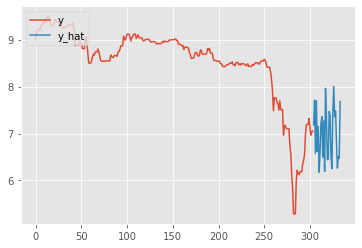

In [18]:
plot_prediction(y_test['y'], y_hat['y_hat'])

In [19]:
esrnn = ESRNN(max_epochs=30, batch_size=8, learning_rate=1e-3, 
              seasonality=30, input_size=30, output_size=30)
esrnn.fit(X_train, y_train, random_seed=1)

========== Training ESRNN ==========

========= Epoch 0 finished =========
Training time: 4.832481861114502
Forecast loss: 0.06182420253753662
========= Epoch 1 finished =========
Training time: 4.787511110305786
Forecast loss: 0.050704434514045715
========= Epoch 2 finished =========
Training time: 4.924712896347046
Forecast loss: 0.05000962316989899
========= Epoch 3 finished =========
Training time: 4.906938791275024
Forecast loss: 0.04790998995304108
========= Epoch 4 finished =========
Training time: 4.854079008102417
Forecast loss: 0.04835346341133118
========= Epoch 5 finished =========
Training time: 4.898065805435181
Forecast loss: 0.04687555134296417
========= Epoch 6 finished =========
Training time: 5.032067060470581
Forecast loss: 0.04716150462627411
========= Epoch 7 finished =========
Training time: 5.00151515007019
Forecast loss: 0.046570785343647
========= Epoch 8 finished =========
Training time: 5.055521011352539
Forecast loss: 0.04694803059101105
========= Epoch 9 f

In [30]:
uniques = y_train['unique_id'].unique()
y_test = y_train.loc[y_train['unique_id']==uniques[120]]
y_hat = esrnn.predict(y_test)

y_hat.shape torch.Size([1, 30])
seasonalities.shape torch.Size([1, 333])
n_time 303
output_size 30
y_hat tensor([[23.6778, 25.0456, 24.6004, 25.3280, 23.0770, 24.7041, 23.8709, 23.9310,
         25.6578, 25.1675, 25.9285, 25.9027, 25.1018, 25.0779, 23.7830, 24.1149,
         24.7799, 25.9102, 25.3029, 24.8202, 24.3818, 25.4409, 25.6844, 25.7309,
         24.3098, 24.2214, 25.4219, 25.2808, 25.1920, 24.9154]])
levels[:, [n_time-1] tensor([[24.5549]])
y_hat tensor([[39.3821, 41.4749, 40.7313, 42.0353, 38.3051, 41.0221, 39.1740, 39.0516,
         41.6907, 41.2554, 42.6359, 42.4847, 40.9378, 40.8848, 39.2230, 39.6994,
         41.1564, 42.9692, 41.9281, 41.8555, 41.3070, 42.2628, 42.2957, 42.4709,
         40.2550, 39.0722, 42.6957, 42.2280, 41.7775, 41.3900]])
seasonalities[:, n_time:(n_time+output_size)] tensor([[1.6633, 1.6560, 1.6557, 1.6596, 1.6599, 1.6605, 1.6411, 1.6318, 1.6249,
         1.6392, 1.6444, 1.6402, 1.6309, 1.6303, 1.6492, 1.6463, 1.6609, 1.6584,
         1.6570, 1.6863,

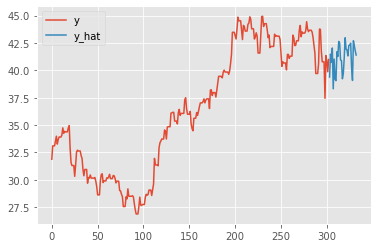

In [31]:
plot_prediction(y_test['y'], y_hat['y_hat'])